In [47]:
import datetime
import pandas as pd
import os
import matplotlib.pylab as pylab

DATADIR = "data/csse"

def get_filenames():
    filenames = os.listdir(DATADIR)
    filenames = sorted([f for f in filenames if f.endswith(".csv")])
    
    # Only start with data after 3/22 because incomplete columns before that
    out = []
    for f in filenames:
        date = f.split('.')[0]
        if datetime.datetime.strptime(date, '%m-%d-%Y') <= datetime.datetime(2020, 3, 22):
            continue
        out.append(f)
    return out

def read_csvs():

    # Get data from multiple csv's into one dataframe
    csvs = get_filenames()
    df = None
    for i in range(len(csvs)):
        filename = csvs[i]
        filepath = DATADIR + "/" + filename
        date = filename.split(".")[0]

        df_onedate = pd.read_csv(filepath)
        df_onedate = df_onedate[['Confirmed', 'Province_State', 'Admin2']]
        df_onedate.rename(columns={'Confirmed': 'confirmed', 'Province_State': 'state', 'Admin2' : 'county'}, inplace=True)
        df_onedate['date'] = date
        df_onedate['date'] = pd.to_datetime(df_onedate['date'])

        if i==0:
            df = df_onedate
        else:
            df = df.append(df_onedate)
    
    #df['date'] = pd.to_datetime(df['date'])
    
    return df

df = read_csvs()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303580 entries, 0 to 3755
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   confirmed  303580 non-null  int64         
 1   state      287296 non-null  object        
 2   county     268092 non-null  object        
 3   date       303580 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 11.6+ MB


In [48]:
def df_onecounty(df_all, county, state):
    temp = df[(df['state'] == state) & (df['county'] == county)]
    temp = temp.sort_values(by=['state', 'county','date'])
    temp['new_cases'] = temp.groupby(['state', 'county'])['confirmed'].diff().fillna(0)
    return temp

In [49]:
df.head(100)

,confirmed,state,county,date
0,1,South Carolina,Abbeville,2020-03-23
1,1,Louisiana,Acadia,2020-03-23
2,1,Virginia,Accomack,2020-03-23
3,13,Idaho,Ada,2020-03-23
4,1,Iowa,Adair,2020-03-23
...,...,...,...,...
95,1,Louisiana,Assumption,2020-03-23
96,2,Texas,Atascosa,2020-03-23
97,0,Kansas,Atchison,2020-03-23
98,0,Missouri,Atchison,2020-03-23


In [50]:
import matplotlib.pyplot as plt
import numpy as np

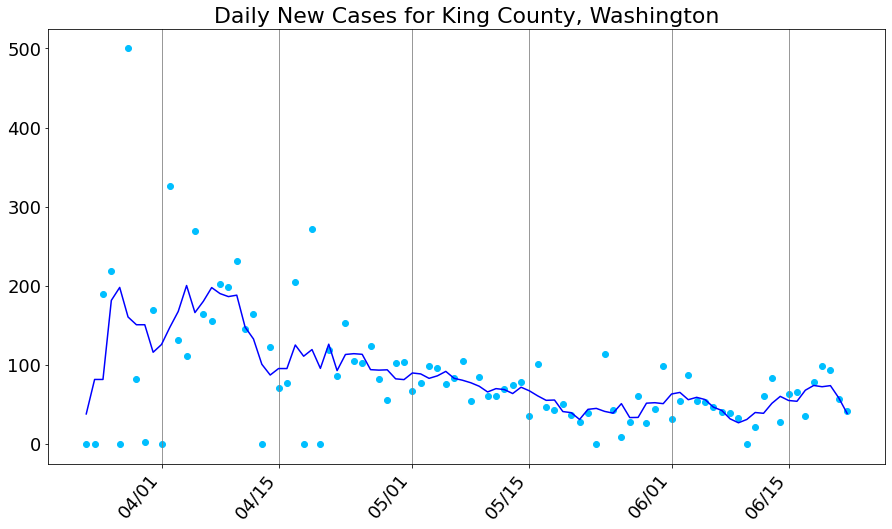

In [69]:
def moving_average(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')


def add_labels(ax, x, y):
    # zip joins x and y coordinates in pairs
    for x1,y1 in zip(x,y):
        label = "{}".format(int(y1))
        ax.annotate(
            label, # this is the text
            (x1,y1), # this is the point to label
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center', # horizontal alignment can be left, right or center
            color='deepskyblue',
            size=12
        ) 

    


        
def plot_it(df, county, state, filename, labels=False):
    x = df['date'].to_numpy()
    y = df['new_cases'].to_numpy()
    y_avg = moving_average(y, 5)
    
    params = {'legend.fontsize': 22,
          'figure.figsize': (15, 8),
         'axes.labelsize': 18,
         'axes.titlesize':22,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
    pylab.rcParams.update(params)
    import matplotlib.dates as mdates
    
    
    fig, ax = plt.subplots()
    
    # Plot data
    ax.scatter(x, y, color='deepskyblue')
    ax.plot(x, y_avg, color='blue')
    
    # Add label values to data points
    if labels:
        add_labels(ax, x, y)
    
    # Formatting
    ax.set_title(label='Daily New Cases for ' + county + ' County, ' + state, fontsize=22)
    ax.grid(axis='x', color='gray')
    
    # Rotate x axis dates
    for label in ax.get_xticklabels():
        label.set_rotation(50)
        label.set_horizontalalignment('right')
        
    # Make x axis dates shorter
    myFmt = mdates.DateFormatter('%m/%d')
    ax.xaxis.set_major_formatter(myFmt)

    plt.savefig(filename)
    

county = 'King'
state = 'Washington'

df1 = df_onecounty(df, county, state)
plot_it(df1, county, state, 'test.png')
plt.show()

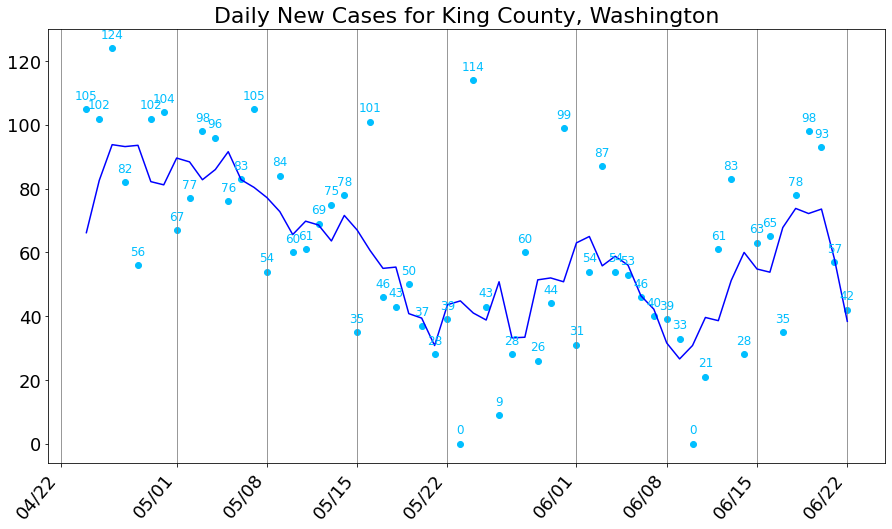

In [70]:
df2 = df1.tail(60)
plot_it(df2, county, state, 'test2.png', True)